In [1]:
import sys
sys.path.append('../src')

from unet_preprocessing import DataProcessor
#from unet_prediction import ImagePadding
from model import unet, unet_wo_weighting, unet_inference, unet_reduced, unet_reduced_inference

import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import os

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

path = '/cluster/work/sis/cdss/oschmanf/ackermann-bacteria-segmentation/data/unet/Vibrio_natriegens/'
#path = '../data/unet/Vibrio_natriegens/'

path_base = '/cluster/work/sis/cdss/oschmanf/ackermann-bacteria-segmentation/data/data_Glen/unet/mCherry/'
path_img = path + 'train/img/'
path_mask = path + 'train/mask/'
path_img_test = path + 'test/img/'

Using TensorFlow backend.


In [2]:
class DataProcessor2():

    def __init__(self, sigma = 2, w_0 = 2, w_c0 = 1, w_c1 = 1.1, 
                                    num_patches = 10, n_splits=1, test_size=0.3):
        #self.path = path

        self.sigma = sigma # param for dist matrix
        self.w_0 = w_0 # param for dist matrix
        self.w_c0 = w_c0 # weight of background pixels
        self.w_c1 = w_c1 # weight of foreground pixels

        self.num_patches = num_patches #number of patches along x/y-axis
        self.n_splits = n_splits
        self.test_size = test_size

    def define_horizontal_splits(self, img):
        '''
        This method defines the random starting heights of the horizontal splits. 
        The height of the resulting horizontal patch is quarter the height of the 
        original image. The width of the horizontal patch is the width of the original
        image.
        '''
        height, width = img.shape

        # define the minimum height (split_start) of random splits
        num_splits = 150
        self.height_cutoff = 16*(height // (4*16)) # random patch should have the quarter height of the original image
        self.split_start = np.linspace(0, height, num_splits, dtype = int)

        
    def horizontal_split(self, img):
        '''
        This method splits an image into random horizontal patches accoring to
        previously defined starting heights of the horizontal splits. The image is 
        horizontally mirrored before the split to to use the full height of the image.
        '''

        # split image according to where split starts
        hor_splits = []
        img_mirrored = self.pad_horizontally(img)
        for start in self.split_start:
            hor_splits.append(img_mirrored[start:(start+self.height_cutoff), :])
        hor_splits = np.array(hor_splits)

        return hor_splits
    
    
    def get_max_shape(self, imgs):
        '''
        This method gets the maximal height and width across all images
        in a dataset. The maximal height and width are also set to a 
        multiple of 16 to allow an even split of feature maps in the unet.
        '''
        imgs_shape = [i.shape for i in imgs]
        self.height_max = int(np.ceil(np.max([s[0] for s in imgs_shape])/16)*16)
        self.width_max = int(np.ceil(np.max([s[1] for s in imgs_shape])/16)*16)
        
        
    def pad_horizontally(self, img):
        '''
        This method mirrors an image horizontally.
        '''
        horizontal_mirrored = np.concatenate([img, img[::-1,:]])
        return horizontal_mirrored
    
    
    def pad_image(self, img):
        '''
        This method pads an image with its horizontal and vertical mirror 
        image and reduces the image size according to the maximal height 
        and width of all images in the dataset.
        '''
        #horizontal_mirrored = np.concatenate([img, img[::-1,:]])
        horizontal_mirrored = np.concatenate([img, np.zeros(img.shape)])
        horizontal_pad = horizontal_mirrored[:self.height_max, :]
        #vertical_mirrored = np.hstack([horizontal_pad, horizontal_pad[:,::-1]])
        vertical_mirrored = np.hstack([horizontal_pad, np.zeros(horizontal_pad.shape)])
        final_pad = vertical_mirrored[:, :self.width_max]
        
        return final_pad

In [3]:
proc = DataProcessor()
proc2 = DataProcessor2()

# load data
list_imgs = np.sort(os.listdir(path_img))
imgs_unpad = [proc.scale_pixel_vals(io.imread(path_img + i, as_gray=True)) for i in list_imgs]
list_masks = np.sort(os.listdir(path_mask))
masks_unpad = [proc.scale_pixel_vals(io.imread(path_mask + m).astype(int)) for m in list_masks]

# padding of images and masks
proc2.get_max_shape(imgs_unpad)
imgs = np.array([proc2.pad_image(i) for i in imgs_unpad])
masks = np.array([proc2.pad_image(m) for m in masks_unpad])

# split into train and test set
X_train, X_val, y_train, y_val = train_test_split(imgs, masks, test_size=0.3)

# # horizontal splits/patches
proc2.define_horizontal_splits(imgs[0])
X_train_rand = np.concatenate([proc2.horizontal_split(xtrain) for xtrain in X_train])
X_val_rand = np.concatenate([proc2.horizontal_split(xval) for xval in X_val])
y_train_rand = np.concatenate([proc2.horizontal_split(ytrain) for ytrain in y_train])
y_val_rand = np.concatenate([proc2.horizontal_split(yval) for yval in y_val])

# data augmentation
X_train_aug, y_train_aug, weight_maps_train_aug = proc.data_augmentation(X_train_rand, y_train_rand, y_train_rand)
X_val_aug, y_val_aug, weight_maps_val_aug = proc.data_augmentation(X_val_rand, y_val_rand, y_val_rand)

# return



# # generate weight map
# #weight_maps = np.array([self.generate_weight_map(m) for m in masks])
# #print(weight_maps.shape)



# return X_train_aug, y_train_aug, X_val_aug, y_val_aug

[  0   2   5   8  11  13  16  19  22  25  27  30  33  36  39  41  44  47
  50  53  55  58  61  64  67  69  72  75  78  80  83  86  89  92  94  97
 100 103 106 108 111 114 117 120 122 125 128 131 134 136 139 142 145 147
 150 153 156 159 161 164 167 170 173 175 178 181 184 187 189 192 195 198
 201 203 206 209 212 214 217 220 223 226 228 231 234 237 240 242 245 248
 251 254 256 259 262 265 268 270 273 276 279 281 284 287 290 293 295 298
 301 304 307 309 312 315 318 321 323 326 329 332 335 337 340 343 346 348
 351 354 357 360 362 365 368 371 374 376 379 382 385 388 390 393 396 399
 402 404 407 410 413 416]


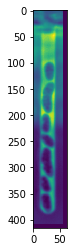

In [4]:
plt.imshow(imgs[0])

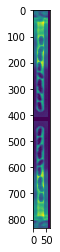

In [5]:
plt.imshow(proc2.pad_horizontally(imgs[0]))

In [6]:
X_train_rand.shape

(1050, 96, 64)

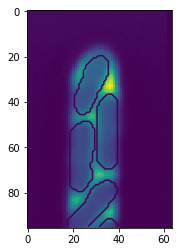

In [7]:
plt.imshow(X_train_aug[-1])
plt.contour(y_train_aug[-1], [0.5])

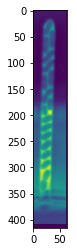

In [8]:
plt.imshow(imgs[4])

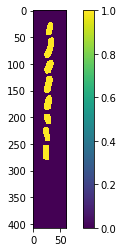

In [9]:
plt.imshow(masks_unpad[9])
plt.colorbar()

In [10]:
#X_train, y_train, weight_maps_train, X_val, y_val, weight_maps_val = proc.run_mother_machine(path_img_train, path_mask_train)
X_train, y_train, X_val, y_val = proc.run_mother_machine(path_img, path_mask)

[  0   3   7  10  14  17  21  24  28  32  35  39  42  46  49  53  56  60
  64  67  71  74  78  81  85  88  92  96  99 103 106 110 113 117 120 124
 128 131 135 138 142 145 149 152 156 160 163 167 170 174 177 181 184 188
 192 195 199 202 206 209 213 216 220 224 227 231 234 238 241 245 248 252
 256 259 263 266 270 273 277 280 284 288 291 295 298 302 305 309 312 316
 320 323 327 330 334 337 341 344 348 352]


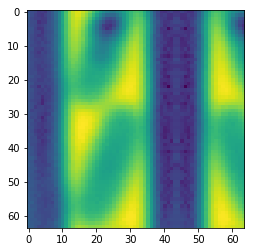

In [11]:
plt.imshow(X_train[30])

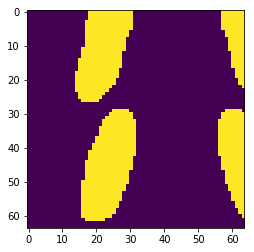

In [12]:
plt.imshow(y_train[30])